In [1]:
import os
import flexynesis
import torch
import numpy as np
import seaborn as sns
import pandas as pd
import random
import lightning as pl

Seed set to 42


In [2]:
import glob
all_result = glob.glob('*/job.stats.csv')
pd_result = []
for i in range(0,len(all_result)):
    combination = os.path.dirname(all_result[i])
    result = pd.read_csv(all_result[i],header=0,sep=',')
    result = result[result['metric'] == 'pearson_corr']
    result['combination'] = combination
    pd_result.append(result)
pd_result = pd.concat(pd_result).reset_index(drop=True)
pd_result = pd_result.sort_values(by=['value'],ascending=False).reset_index(drop=True)
pd_result.head()

,method,var,variable_type,metric,value,combination
0,DirectPred,Erlotinib,numerical,pearson_corr,0.445724,DirectPred_mutation_rna_early
1,DirectPred,Erlotinib,numerical,pearson_corr,0.427273,DirectPred_mutation_rna_intermediate
2,DirectPred,Erlotinib,numerical,pearson_corr,0.425258,DirectPred_mutation_rna_cnv_intermediate
3,supervised_vae,Erlotinib,numerical,pearson_corr,0.420191,supervised_vae_mutation_rna_early
4,GNN,Erlotinib,numerical,pearson_corr,0.406158,GNN_mutation_rna_GC


In [3]:
best_combination = pd_result.loc[0,'combination']
best_combination

'DirectPred_mutation_rna_early'

In [4]:
model = torch.load(f'{best_combination}/job.final_model.pth',weights_only=False)


In [5]:
model

DirectPred(
  (log_vars): ParameterDict(  (Erlotinib): Parameter containing: [torch.FloatTensor of size 1])
  (encoders): ModuleList(
    (0): MLP(
      (layer_1): Linear(in_features=1429, out_features=453, bias=True)
      (layer_out): Linear(in_features=453, out_features=35, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (batchnorm): BatchNorm1d(453, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (MLPs): ModuleDict(
    (Erlotinib): MLP(
      (layer_1): Linear(in_features=35, out_features=26, bias=True)
      (layer_out): Linear(in_features=26, out_features=1, bias=False)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (batchnorm): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
)

In [6]:
train_embeddings = pd.read_csv(f'{best_combination}/job.embeddings_train.csv',header=0,sep=',',index_col=0)
test_embeddings = pd.read_csv(f'{best_combination}/job.embeddings_test.csv',header=0,sep=',',index_col=0)
train_embeddings.head()

,E0,E1,E2,E3,E4,E5,E6,E7,E8,E9,...,E25,E26,E27,E28,E29,E30,E31,E32,E33,E34
JHUEM-3,-0.630973,-1.303404,0.755052,0.793347,0.534226,-0.890763,-0.168734,0.464402,1.125075,0.274853,...,0.928379,0.369427,0.336545,-0.066174,0.762387,0.321855,-0.393500,0.098959,0.346849,-0.758049
SaOS-2,-0.532181,0.724958,-0.749626,-0.884739,-0.026233,0.273333,-0.883810,0.813768,-1.141616,-1.066310,...,-0.638039,1.418703,0.189523,0.373905,0.555127,-0.736129,1.442372,-0.597179,-1.343380,-0.208160
MDA-MB-361,-0.029137,-0.074693,0.077872,0.231307,0.210320,0.241797,0.543754,0.131521,0.664559,0.098674,...,0.709410,-0.159578,0.802244,0.436839,0.114099,0.398196,-0.087826,-0.071205,0.283864,-0.712322
SNU-C5,-0.489563,-0.680598,0.202466,0.174731,0.220123,0.255561,0.191929,0.011733,1.070043,0.546152,...,0.504204,-0.456335,0.320976,0.313901,0.498280,0.890834,-0.869828,0.636760,0.915395,-1.029051
HLE,-0.380108,0.304782,-0.174249,-0.482121,-0.039605,-0.041486,-0.223698,0.323943,-0.634807,-0.229475,...,-0.524931,0.483700,-0.027664,0.203619,0.126134,-0.380189,0.813694,0.052384,-0.274817,0.057034


In [7]:
train_clin_info = pd.read_csv('ccle_vs_gdsc/train/clin.csv',header=0,sep=',',index_col=0)
train_labels = train_clin_info.loc[train_embeddings.index,'tissueid'].values
test_clin_info = pd.read_csv('ccle_vs_gdsc/test/clin.csv',header=0,sep=',',index_col=0)
test_labels = test_clin_info.loc[test_embeddings.index,'tissueid'].values
train_labels

array(['Uterus', 'Bone', 'Breast', ..., 'Lung', 'Pancreas', 'Lymphoid'],
      dtype=object)

/public/home/liujunwu/software/miniconda3/envs/ame/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


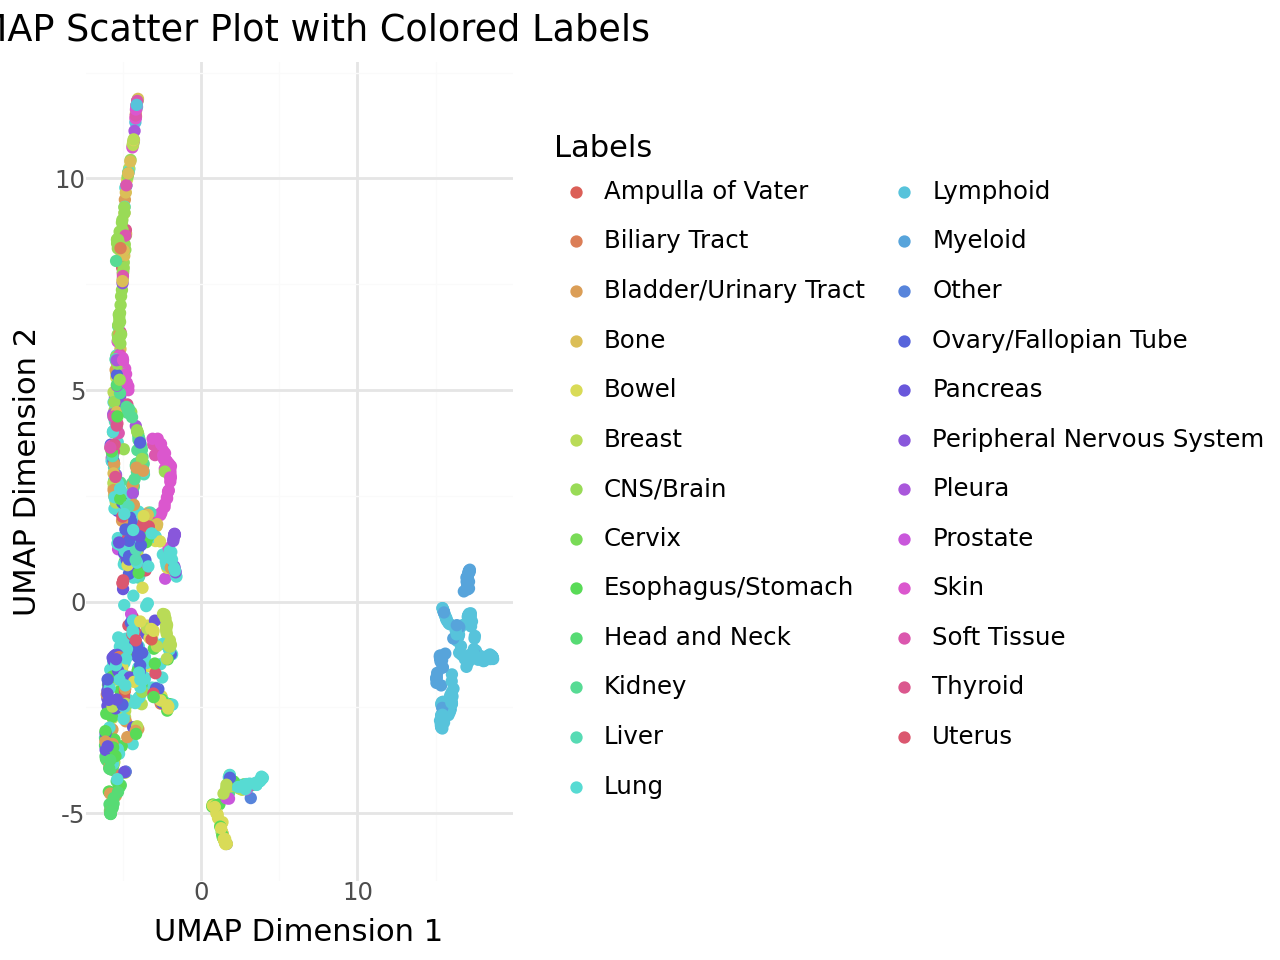

In [8]:
flexynesis.plot_dim_reduced(train_embeddings, train_labels, color_type = 'categorical', method='umap')

/public/home/liujunwu/software/miniconda3/envs/ame/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


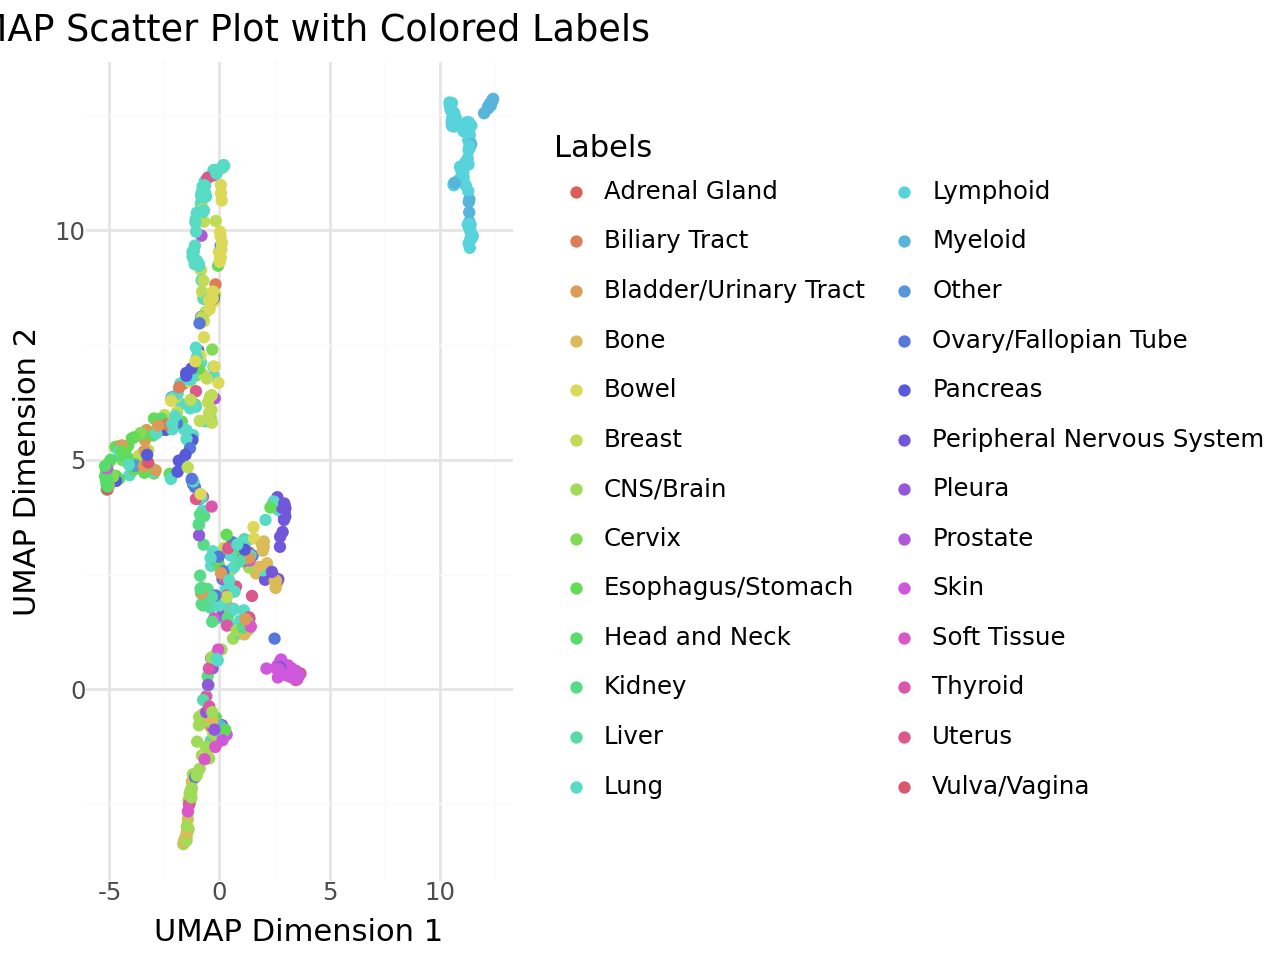

In [9]:
flexynesis.plot_dim_reduced(test_embeddings, test_labels, color_type = 'categorical', method='umap')

In [14]:
flexynesis.get_important_features(model, var = 'Erlotinib', top=10)

,target_variable,target_class,target_class_label,layer,name,importance
0,Erlotinib,0,,all,ABLIM3,0.002692
1,Erlotinib,0,,all,KRAS,0.002576
2,Erlotinib,0,,all,DKK1,0.002158
3,Erlotinib,0,,all,TBC1D30,0.002060
4,Erlotinib,0,,all,CXADR,0.002033
5,Erlotinib,0,,all,SH3YL1,0.002023
6,Erlotinib,0,,all,MICAL1,0.002021
7,Erlotinib,0,,all,ICA1,0.001981
8,Erlotinib,0,,all,EFHD1,0.001972
9,Erlotinib,0,,all,SALL2,0.001971


1.KRAS has been reported associated with Erlotinib many times.

2.DKK1 is one of independent prognostic in lung cancer high-risk group, which exhibited drug sensitivity to Erlotinib [PMID:40034678]

3.ABLIM3, TBC1D30, CXADR, SH3YL1, MICAL1, ICA1, EFHD1, SALL2 have not been reported to be associated with Erlotinib yet